In [173]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.rcParams["xtick.labelsize"] = 18
matplotlib.rcParams["ytick.labelsize"] = 18
# matplotlib.rcParams["image.cmap"] = "Purples"
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 18
matplotlib.rcParams["axes.labelsize"] = 18
import matplotlib.pyplot as plt
import scipy.linalg

import drive
import TLS
import emission_TLS
import scattering_pulsed_TLS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# compute single-photon S matrix elements
gamma = 0.181
modulation = drive.sinDrive(0, 0, 0, 0)    # unmodulated TLS
tlsObj = TLS.modulatedTLS(0, gamma, modulation)
pulseWidthUD = 0.0/gamma
pulseAmpUD = 0.0*gamma
laserPulseUD = drive.pulseDrive(pulseAmpUD, pulseWidthUD)
timeSteps = np.linspace(-20/gamma, 20/gamma, 1001)
TpInd = 600

sinPhoSMatEleUD = scattering_pulsed_TLS.singlePhotonSMatrix(tlsObj, timeSteps, laserPulseUD, TpInd)

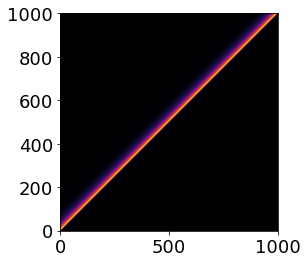

In [139]:
plt.figure()
plt.imshow((np.abs(sinPhoSMatEleUD)**2), aspect=1, origin="lower")

In [140]:
pulseWidthD = 4.0/gamma
pulseAmpD = 5.0*gamma
laserPulseD = drive.pulseDrive(pulseAmpD, pulseWidthD)
    
sinPhoSMatEleD = scattering_pulsed_TLS.singlePhotonSMatrix(tlsObj, timeSteps, laserPulseD, TpInd)

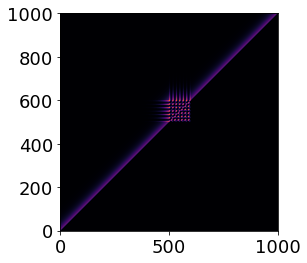

In [141]:
plt.figure()
plt.imshow((np.abs(sinPhoSMatEleD)**2), aspect=1, origin="lower")

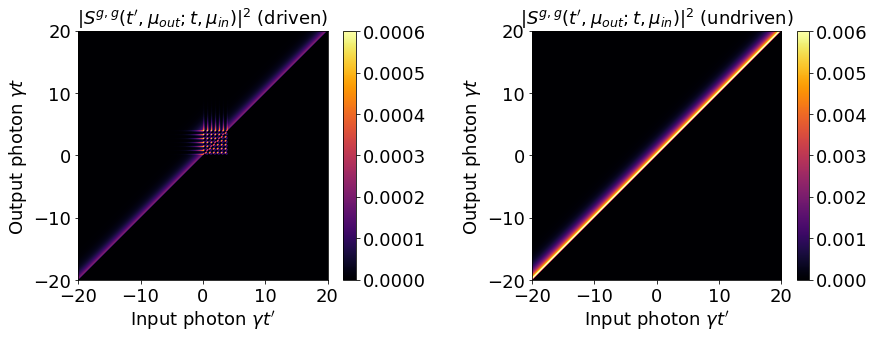

In [158]:
plt.figure(figsize=(13, 13))
plt.subplot(1, 2, 1)
plt.imshow((np.abs(sinPhoSMatEleD)**2), aspect=1, origin="lower",
           extent=[gamma*timeSteps[0], gamma*timeSteps[-1],
                   gamma*timeSteps[0], gamma*timeSteps[-1]])
plt.xlabel("Input photon $\gamma t'$")
plt.ylabel("Output photon $\gamma t$")
plt.title("$|S^{g,g}(t',\mu_{out};t,\mu_{in})|^2$ (driven)")
plt.clim(0.0, 0.0006)
plt.colorbar(shrink=0.29)
plt.subplot(1, 2, 2)
plt.imshow((np.abs(sinPhoSMatEleUD)**2), aspect=1, origin="lower",
           extent=[gamma*timeSteps[0], gamma*timeSteps[-1],
                   gamma*timeSteps[0], gamma*timeSteps[-1]])
plt.xlabel("Input photon $\gamma t'$")
plt.ylabel("Output photon $\gamma t$")
plt.title("$|S^{g,g}(t',\mu_{out};t,\mu_{in})|^2$ (undriven)")
plt.clim(0.0, 0.006)
plt.colorbar(shrink=0.29)
plt.tight_layout(pad=4.0)
plt.savefig("scatt.eps")

In [183]:
def transmission(sinPhoSMat: np.ndarray, inpPhoFunc: drive.normInputPhotonProfile, dts: np.array) -> float:
    """
    Compute the transmission of a input Gaussian single-photon pulse.

    Args:
        sinPhoSMat: The single-photon scattering matrix elements;
        inpPhoFunc: The input-photon profile function;
        dts: The time steps for both input and output photons.
    """
    outProfile = []
    for tPrime in range(dts.size):
        gOutTPrime = 0.0 + 0.0j
        for t in range(dts.size):
            inputTime = dts[t]
            gOutTPrime += sinPhoSMat[tPrime][t]*inpPhoFunc(inputTime)*(dts[1] - dts[0])
        outProfile.append(gOutTPrime)

    return np.sum(np.abs(outProfile)**2)*(dts[1] - dts[0])


def transmissionVScentFreq(sinPhoSMat: np.array, spatialExtent: float, centralFreqArray: np.array, dts: np.array) -> np.array:
    """
    Compute the transmission of a input Gaussian single-photon pulse as a function of central frequency of the photon.

    Args:
        sinPhoSMat: The single-photon scattering matrix elements;
        spatialExtent: The spatial extent of the input photon profile;
        centralFreqArray: The central frequency array for input photons;
        dts: The time steps for both input and output photons.
    """
    trans = []

    for centralFreq in centralFreqArray:
        inputProf = drive.normInputPhotonProfile(spatialExtent, centralFreq)
        trans.append(transmission(sinPhoSMat, inputProf, dts))

    return trans

In [189]:
spatialExtent = 2.0/gamma
centralFreqArray = np.linspace(-5.0, 5.0, 1000)
transmissionUD = scattering_pulsed_TLS.transmissionVScentFreq(sinPhoSMatEleUD, spatialExtent, centralFreqArray, timeSteps)
transmissionD = scattering_pulsed_TLS.transmissionVScentFreq(sinPhoSMatEleD, spatialExtent, centralFreqArray, timeSteps)

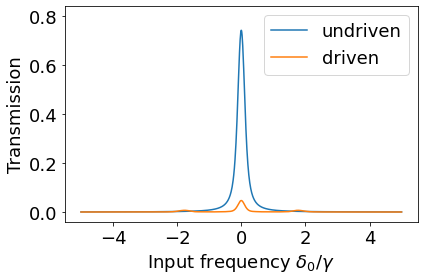

In [195]:
plt.figure()
plt.plot(centralFreqArray, transmissionUD, label="undriven")
plt.plot(centralFreqArray, transmissionD, label="driven")
plt.xlabel("Input frequency $\delta_0/\gamma$")
plt.ylabel("Transmission")
plt.ylim(-0.04, 0.84)
plt.legend(fontsize=18, loc=1)
plt.tight_layout()
plt.savefig("tran.pdf")